## Impact of transaction fee & timing

**e.g.** Binance: maker: 0.00075, taker: 0.001

#### **Problem setup:**

Paramters: 
- $X \in \mathbb{R}^{n \times n}$ where $X_{i,j}$ represents the amount transit from i to j. 
    - $X_{m,n} = 0$ if we couldn't transit from i to j  
- $T \in \mathbb{R}^{n \times n}$ where $T_{i,j}$ represents the price of i in terms of j. 

Objective: 
- $\max \sum_{i,j}(TX^T)_{i,j}$

Constraints: 
- $\sum_j X_{ij} - \sum_j X_{ji} = 0 \quad \forall i$  i.e. inflow = outflow 
- $X_{ij} > 0 \quad \forall i,j$
- $||X||_k \leq 1$


#### **Original setting**

Assume we have market for $i/j$ (we are market price taker),

$$T_{i,j} = log(\frac{P_i}{P_j}) = log( bid )$$ 

Bid for $i/j$ is the price of transferring i for j; ask for $i/j$ is the price of transferring j for i

$$T_{j,i} = log(\frac{P_j}{P_i}) = 1 / log( ask  )$$ 


Final return is $\sum_{i,j}(TX^T)_{i,j}$
 - note: for an arbitrage-free market, final return should always be lower than 0.


#### **Transaction Fee**
**If transaction fee rate $\delta$ exist**, then we have

$$T_{i,j} = log(\frac{P_i}{P_j} \cdot e^{-\delta}) = log(\frac{P_i}{P_j}) - \delta$$

Final return becomes $\sum_{i,j}(TX^T)_{i,j} - \delta\sum_{i,j}X_{i,j} $
 - note: if we use 1-norm here, the existence of transaction fee won't change optimal $X^*$

In [175]:
import networkx as nx
import copy
import numpy as np
import cvxpy as cp
import pandas as pd
import matplotlib.pyplot as plt


def init(df): 
    # init currency info 
    syms = df.symbol.unique()
    currency_set = set()
    for s in syms: 
        currency_set.add(s.split("/")[0])
        currency_set.add(s.split("/")[1])
    currency_set = list(currency_set)
    currency2index = {}
    for i, s in enumerate(currency_set): 
        currency2index[s] = i
    return currency_set, currency2index

def update_price_mtx(df, currency_set, currency2index): 
    transit_price_mtx = np.ones((len(currency_set), len(currency_set)))
    for i in range(len(df)): 
        ticker = df["symbol"].iloc[i]
        base = ticker.split("/")[0]
        quote = ticker.split("/")[1]
        if base in currency_set and quote in currency_set: 
            base_idx = currency2index[base]
            quote_idx = currency2index[quote]
            transit_price_mtx[base_idx, quote_idx] = df["bid"].iloc[i]
            transit_price_mtx[quote_idx, base_idx] = 1 / df["ask"].iloc[i]
    return transit_price_mtx
    
def get_var_loc(df, currency_set, currency2index): 
    var_loc = np.zeros((len(currency_set), len(currency_set)))
    for s in df.symbol.unique(): 
        base = s.split("/")[0]
        quote = s.split("/")[1]
        base_idx = currency2index[base]
        quote_idx = currency2index[quote]
        var_loc[base_idx, quote_idx] = 1
        var_loc[quote_idx, base_idx] = 1 
    return var_loc

def update_obj(price_mtx, var_loc, currency_set, cost = 0, norm = "fro"): 
    if norm == "fro": 
        xnorm = lambda x: cp.norm(x, "fro")
    elif norm == 1:
        xnorm = lambda x: cp.sum(cp.abs(x))
        
    transit_mtx = np.log(price_mtx)
    # transit_mtx = transit_mtx[var_loc]
    X = cp.Variable((len(currency_set), len(currency_set)))
    obj = cp.Maximize(cp.sum(cp.multiply(transit_mtx, X.T)) - cost * cp.sum(X))
    constraints = [
        X >= 0, 
        X @ np.ones(len(currency_set)) ==  X.T @ np.ones(len(currency_set)), 
        xnorm(X) <= 1
    ]
    constraints += [X[i, j] == 0 for i in range(len(currency_set)) for j in range(len(currency_set)) if var_loc[i, j] == 0]
    prob = cp.Problem(obj, constraints) 
    prob.solve()
    print("status:", prob.status)
    print("optimal value", prob.value)
    return X.value


def find_arbitrage(df, cost = 0, norm = "fro"): 
    currency_set, currency2index = init(df)
    price_mtx = update_price_mtx(df, currency_set, currency2index)
    var_loc = get_var_loc(df, currency_set, currency2index)
    X = update_obj(price_mtx, var_loc, currency_set, cost, norm)
    return X, price_mtx, currency2index

def xsummerize(X, currency2index, verbose=0):
    idx2currency = {v: k for k, v in currency2index.items()}
    x = xfilter(X, threshold=1e-3)
    transactions = []
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            if x[i, j] != 0:
                if verbose:
                    print(idx2currency[i], "->", idx2currency[j], ":", x[i, j])
                transactions.append((idx2currency[i], idx2currency[j], x[i, j]))
    out_curr = set([i[0] for i in transactions])
    in_curr = set([i[1] for i in transactions])
    print("involved currencies:", len(out_curr)/len(currency2index), len(in_curr)/len(currency2index))
def make_symbols(coin_set):
    symbols = []
    for i in range(len(coin_set)):
        for j in range(i+1, len(coin_set)):
            symbols.append(coin_set[i] + "/" + coin_set[j])
            symbols.append(coin_set[j] + "/" + coin_set[i])
    return symbols

def get_rtn(price_mtx, X, cost = 0.001):
    return np.sum(np.multiply(np.log(price_mtx), X.T)) - cost * np.sum(X)

In [167]:
data = pd.read_csv("data.csv")
data.sort_values(by=["timestamp"], inplace=True)
timestamps = data.head(10000).timestamp.unique() 
t0 = timestamps[0]

In [176]:
## 1-norm # linear impact

## 2-norm # how does transaction fee affect the arbitrage opportunity
# a very simple case:
coin_set = ["USD", "USDT",  "VTHO",  "FIL"]
symbols = make_symbols(coin_set)
df = data[data.timestamp == t0]
df = df[df.symbol.isin(symbols)].sort_values(by=["symbol"])

X, price_mtx, currency2index = find_arbitrage(df)
rtn_nocost = get_rtn(price_mtx, X, cost=0)

X, price_mtx, currency2index = find_arbitrage(df, cost=0.001)
rtn_cost = get_rtn(price_mtx, X, cost=0.001)



status: optimal
optimal value 0.00819235520421735
status: optimal
optimal value 0.006168189014605521


In [177]:
# see cost impact
def cost_impact(cost, df): 
    X, price_mtx, currency2index = find_arbitrage(df, cost=cost)
    rtn = get_rtn(price_mtx, X, cost=cost)
    return rtn
c = np.linspace(0, 0.01, 100)
cost_impacts = [cost_impact(cost, df) for cost in c]

status: optimal
optimal value 0.00819235520421735
status: optimal
optimal value 0.00798564272286385
status: optimal
optimal value 0.007779339597720242
status: optimal
optimal value 0.007573482728476503
status: optimal
optimal value 0.007368099438621272
status: optimal
optimal value 0.007163243371507118
status: optimal
optimal value 0.0069589564466804475
status: optimal
optimal value 0.006755281434554356
status: optimal
optimal value 0.006552287098792159
status: optimal
optimal value 0.006350013082064101
status: optimal
optimal value 0.006147990686940406
status: optimal
optimal value 0.005945972335310738
status: optimal
optimal value 0.005743956227169046
status: optimal
optimal value 0.005541935027878487
status: optimal
optimal value 0.0053399146450840256
status: optimal
optimal value 0.0051378930327585035
status: optimal
optimal value 0.004935874033020517
status: optimal
optimal value 0.004733855865615504
status: optimal
optimal value 0.004531826275079216
status: optimal
optimal value 

Text(0.5, 1.0, 'transaction fee impact on return')

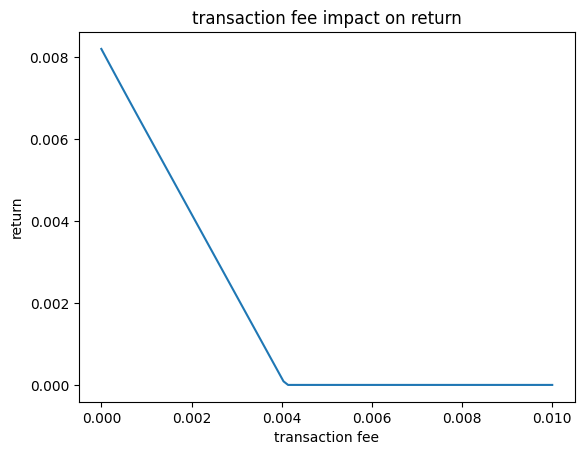

In [178]:
plt.plot(c, cost_impacts)
plt.xlabel("transaction fee")
plt.ylabel("return")
plt.title("transaction fee impact on return") # linear

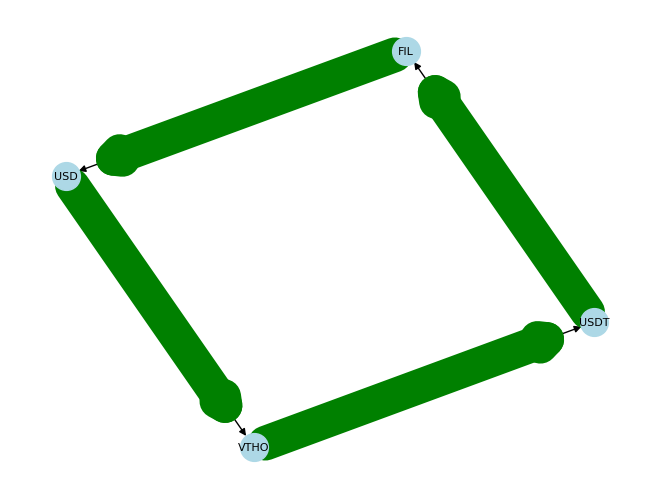

In [163]:
weights = visualize(X, currency2index)

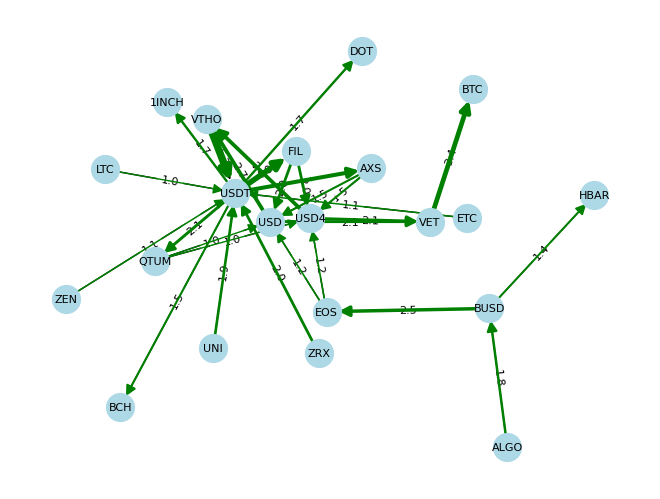

In [79]:
def xfilter(X, threshold=1e-3):
    x = copy.deepcopy(X)
    x[x<threshold] = 0
    return x

def xreweight(X):
    return X/np.sum(X)
    
    
def visualize( X, currency2index ):
    # Create a graph
    G = nx.DiGraph()
    x = xfilter(xreweight(X), threshold=1e-2)
    
    idx2currency = {v: k for k, v in currency2index.items()}
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            if x[i, j] != 0:
                wgt = np.round(x[i, j]*100, 1)
                G.add_edge(idx2currency[i], idx2currency[j], weight=wgt)
    # Draw the graph
    
    weights = nx.get_edge_attributes(G, 'weight')

    # Draw the graph
    pos = nx.spring_layout(G, k=5, iterations=300)  # Generate positions
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=400, font_size=8, arrows=True)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=weights, font_size=8, alpha=1)  # Display edge weights
    nx.draw_networkx_edges(G, pos, edge_color='green', arrowsize=15, 
                        width=[weights[edge]  for edge in G.edges])  # Scale thickness

    plt.show()
    return weights
    
weights = visualize(X, currency2index)

#### How long can an arbitrage opportunity last

In [196]:
data_sub = data[(data.symbol.isin(symbols))]
timestamps = data0_sub.timestamp.unique()

rtns = {}
currency_set, currency2index = init(df)

for idx, t in enumerate( timestamps ):
    tmp_df = data_sub[data_sub.timestamp == t]
    X, price_mtx, currency2index = find_arbitrage(tmp_df, cost=0.001)
    rtn_list = []
    for t1 in timestamps[idx:]:
        tmp_df = data_sub[data_sub.timestamp == t1]
        price_mtx = update_price_mtx(tmp_df, currency_set, currency2index)
        rtn = get_rtn(price_mtx, X, cost=0.001)
        if rtn > 0:
            rtn_list.append(rtn)
        else:
            break
    rtns[t] = rtn_list
        


status: optimal
optimal value 0.006168189014606196
status: optimal
optimal value 0.003743353545034761
status: optimal
optimal value 0.004008193892695156
status: optimal
optimal value 0.003970017063256306
status: optimal
optimal value 0.0030975343878480253
status: optimal
optimal value 0.0034642646380839354
status: optimal
optimal value 0.0033029268092390875
status: optimal
optimal value 0.0021889179144150422
status: optimal
optimal value 0.0020881295071902757
status: optimal
optimal value 0.0020881294499607967
status: optimal
optimal value 0.0035020503923441255
status: optimal
optimal value 0.0028326840792178174
status: optimal
optimal value 0.00462664633396489
status: optimal
optimal value 0.00271515785114415
status: optimal
optimal value -7.019271157398588e-10
status: optimal
optimal value 0.0010059532217748346
status: optimal
optimal value 0.0017978001694642673
status: optimal
optimal value 0.002198312942516075
status: optimal
optimal value 0.002232870896195848
status: optimal
optim

In [198]:
len(timestamps)

2998

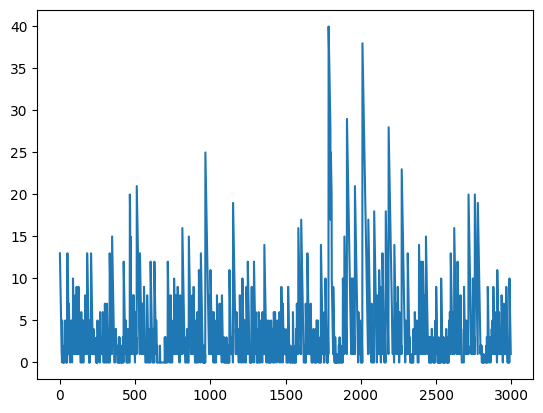

In [199]:
avg_len = [len(v) for k, v in rtns.items()]
plt.plot(range(2998), avg_len)    

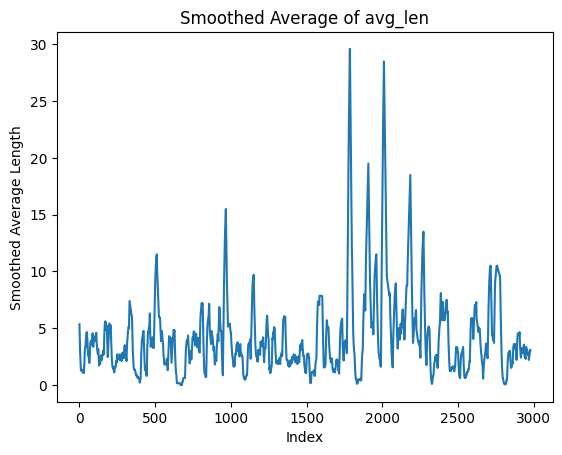

In [202]:
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

window_size = 20
smoothed_avg_len = moving_average(avg_len, window_size)
plt.plot(smoothed_avg_len)
plt.xlabel("Index")
plt.ylabel("Smoothed Average Length")
plt.title("Smoothed Average of avg_len")
plt.show()